## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2

"""
建立神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-4, 1e-8, 0.0]
L2_EXP = [1e-4, 1e-8, 0.0]

In [7]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0721 06:02:44.446331 14100 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0721 06:02:44.449324 14100 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 06:02:44.480240 14100 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 06:02:44.483232 14100 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 06:02:44.487222 14100 

Experiment with L1 = 0.000100, L2 = 0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0721 06:02:44.823324 14100 deprecation.py:323] From C:\Users\weihs\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 225us/step - loss: 6.1325 - acc: 0.2810 - val_loss: 5.9313 - val_acc: 0.3485
Epoch 2/30
50000/50000 [==============================] - 11s 218us/step - loss: 5.8424 - acc: 0.3696 - val_loss: 5.7541 - val_acc: 0.3858
Epoch 3/30
50000/50000 [==============================] - 11s 217us/step - loss: 5.6906 - acc: 0.3969 - val_loss: 5.6251 - val_acc: 0.4072
Epoch 4/30
50000/50000 [==============================] - 11s 220us/step - loss: 5.5645 - acc: 0.4151 - val_loss: 5.5076 - val_acc: 0.4288
Epoch 5/30
50000/50000 [==============================] - 11s 224us/step - loss: 5.4505 - acc: 0.4309 - val_loss: 5.4023 - val_acc: 0.4338
Epoch 6/30
50000/50000 [==============================] - 11s 222us/step - loss: 5.3448 - acc: 0.4423 - val_loss: 5.3012 - val_acc: 0.4491
Epoch 7/30
50000/50000 [==============================] - 11s 225us/step - loss: 5.2461 - acc: 0.4549 - val_loss: 5.

50000/50000 [==============================] - 14s 286us/step - loss: 4.0878 - acc: 0.5437 - val_loss: 4.1722 - val_acc: 0.5039
Epoch 22/30
50000/50000 [==============================] - 14s 280us/step - loss: 4.0206 - acc: 0.5501 - val_loss: 4.1517 - val_acc: 0.4915
Epoch 23/30
50000/50000 [==============================] - 14s 289us/step - loss: 3.9578 - acc: 0.5524 - val_loss: 4.1007 - val_acc: 0.4921
Epoch 24/30
50000/50000 [==============================] - 14s 288us/step - loss: 3.8941 - acc: 0.5585 - val_loss: 4.0115 - val_acc: 0.4966
Epoch 25/30
50000/50000 [==============================] - 15s 296us/step - loss: 3.8366 - acc: 0.5617 - val_loss: 4.0944 - val_acc: 0.4617
Epoch 26/30
50000/50000 [==============================] - 15s 298us/step - loss: 3.7799 - acc: 0.5654 - val_loss: 3.8812 - val_acc: 0.5124
Epoch 27/30
50000/50000 [==============================] - 15s 309us/step - loss: 3.7141 - acc: 0.5708 - val_loss: 3.8374 - val_acc: 0.5145
Epoch 28/30
50000/50000 [=======

50000/50000 [==============================] - 18s 354us/step - loss: 1.8378 - acc: 0.4055 - val_loss: 1.8108 - val_acc: 0.4126
Epoch 4/30
50000/50000 [==============================] - 17s 346us/step - loss: 1.7821 - acc: 0.4270 - val_loss: 1.7569 - val_acc: 0.4318
Epoch 5/30
50000/50000 [==============================] - 17s 338us/step - loss: 1.7367 - acc: 0.4424 - val_loss: 1.7228 - val_acc: 0.4446
Epoch 6/30
50000/50000 [==============================] - 17s 336us/step - loss: 1.6977 - acc: 0.4543 - val_loss: 1.7029 - val_acc: 0.4484
Epoch 7/30
50000/50000 [==============================] - 16s 328us/step - loss: 1.6639 - acc: 0.4647 - val_loss: 1.6762 - val_acc: 0.4596
Epoch 8/30
50000/50000 [==============================] - 16s 327us/step - loss: 1.6344 - acc: 0.4775 - val_loss: 1.6492 - val_acc: 0.4689
Epoch 9/30
50000/50000 [==============================] - 16s 323us/step - loss: 1.6069 - acc: 0.4857 - val_loss: 1.6347 - val_acc: 0.4706
Epoch 10/30
50000/50000 [=============

Epoch 24/30
50000/50000 [==============================] - 14s 290us/step - loss: 1.1994 - acc: 0.5792 - val_loss: 1.3637 - val_acc: 0.5192
Epoch 25/30
50000/50000 [==============================] - 14s 289us/step - loss: 1.1864 - acc: 0.5837 - val_loss: 1.3463 - val_acc: 0.5241
Epoch 26/30
50000/50000 [==============================] - 14s 289us/step - loss: 1.1715 - acc: 0.5878 - val_loss: 1.3808 - val_acc: 0.5135
Epoch 27/30
50000/50000 [==============================] - 15s 290us/step - loss: 1.1593 - acc: 0.5952 - val_loss: 1.3492 - val_acc: 0.5231
Epoch 28/30
50000/50000 [==============================] - 15s 293us/step - loss: 1.1437 - acc: 0.5995 - val_loss: 1.3900 - val_acc: 0.5121
Epoch 29/30
50000/50000 [==============================] - 15s 293us/step - loss: 1.1318 - acc: 0.6024 - val_loss: 1.3648 - val_acc: 0.5200
Epoch 30/30
50000/50000 [==============================] - 15s 297us/step - loss: 1.1179 - acc: 0.6076 - val_loss: 1.3467 - val_acc: 0.5238
Experiment with L1 =

Epoch 7/30
50000/50000 [==============================] - 17s 348us/step - loss: 1.6894 - acc: 0.4577 - val_loss: 1.6916 - val_acc: 0.4503
Epoch 8/30
50000/50000 [==============================] - 19s 376us/step - loss: 1.6600 - acc: 0.4670 - val_loss: 1.6761 - val_acc: 0.4590
Epoch 9/30
50000/50000 [==============================] - 19s 389us/step - loss: 1.6334 - acc: 0.4765 - val_loss: 1.6509 - val_acc: 0.4616
Epoch 10/30
50000/50000 [==============================] - 20s 408us/step - loss: 1.6077 - acc: 0.4834 - val_loss: 1.6232 - val_acc: 0.4760
Epoch 11/30
50000/50000 [==============================] - 21s 411us/step - loss: 1.5843 - acc: 0.4927 - val_loss: 1.6140 - val_acc: 0.4797
Epoch 12/30
50000/50000 [==============================] - 20s 393us/step - loss: 1.5628 - acc: 0.5010 - val_loss: 1.6010 - val_acc: 0.4812
Epoch 13/30
50000/50000 [==============================] - 20s 401us/step - loss: 1.5412 - acc: 0.5069 - val_loss: 1.5880 - val_acc: 0.4925
Epoch 14/30
50000/50000

Epoch 28/30
50000/50000 [==============================] - 14s 275us/step - loss: 1.1570 - acc: 0.5900 - val_loss: 1.3571 - val_acc: 0.5230
Epoch 29/30
50000/50000 [==============================] - 14s 272us/step - loss: 1.1422 - acc: 0.5984 - val_loss: 1.3883 - val_acc: 0.5133
Epoch 30/30
50000/50000 [==============================] - 14s 270us/step - loss: 1.1277 - acc: 0.6032 - val_loss: 1.3475 - val_acc: 0.5309
Experiment with L1 = 0.000000, L2 = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_

In [10]:
results.keys()

dict_keys(['exp-l1-0.0001-l2-0.0001', 'exp-l1-0.0001-l2-1e-08', 'exp-l1-0.0001-l2-0.0', 'exp-l1-1e-08-l2-0.0001', 'exp-l1-1e-08-l2-1e-08', 'exp-l1-1e-08-l2-0.0', 'exp-l1-0.0-l2-0.0001', 'exp-l1-0.0-l2-1e-08', 'exp-l1-0.0-l2-0.0'])

In [12]:
len(results[cond]['train-loss'])

30

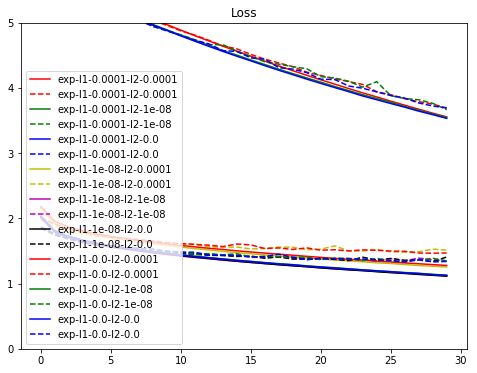

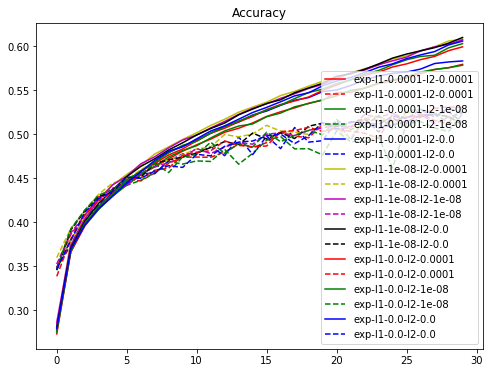

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k", "r", "g", "b",]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()